In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import numpy as np

if torch.cuda.is_available():
    print('Using cuda')
    device = 'cuda'
else:
    print('Using cpu')
    device = 'cpu'

Using cuda


## Data

In [2]:
from data import data_utils

In [3]:
dataset_name = "yacht"
split=0
standardize = True
validation_ratio = 0.0

In [4]:
uci_data = data_utils.get_uci_data(
    dataset_name,
    splits=split,
    standardize=standardize,
    validation_ratio=validation_ratio,
)
dataset, image_dim, label_dim = uci_data
training_dataset, test_dataset = dataset

In [5]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16384, shuffle=True
)

## Model

In [6]:
from utils import train_utils
import yaml

### Load pretrained CARD model

In [7]:
model_path = os.path.join(
    "models",
    "orig_CARD_pretrain",
    dataset_name,
    f"split_{split}",
    "aux_ckpt.pth",
)
aux_states = torch.load(model_path)

config_path = os.path.join(
    "models",
    "orig_CARD_pretrain",
    dataset_name,
    f"split_{split}",
    "config.yml",
)
with open(os.path.join(config_path), "r") as f:
    card_config = yaml.unsafe_load(f)

regressor = train_utils.setup_CARD_model(
    image_dim=image_dim,
    label_dim=label_dim,
    hidden_layers=card_config.diffusion.nonlinear_guidance.hid_layers,
    use_batchnorm=card_config.diffusion.nonlinear_guidance.use_batchnorm,
    negative_slope=card_config.diffusion.nonlinear_guidance.negative_slope,
    dropout_rate=card_config.diffusion.nonlinear_guidance.dropout_rate,
).to(device)

regressor.load_state_dict(aux_states[0])
regressor.eval()

MLP_CARD(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [8]:
test_performance = train_utils.evaluate_CARD_model(
    model=regressor,
    loader=test_loader,
    device=device,
    standardized=standardize,
)
rmse = np.sqrt(test_performance)
print(
    f"Performance of pre-trained regressor on test set: RMSE={round(rmse, 2)}"
)

Performance of pre-trained regressor on test set: RMSE=2.3


### Load diffusion model

In [9]:
# Mixed normal
weights_directory = "results/results_yacht_CARD_pretrain_CARD_backbone/20250708_180112_yacht"
weights_filename = "Datetime_20250708_191945_Loss_yacht_MLP_diffusion_"
deterministic = False

# Deterministic
# weights_directory = "results/results_yacht_CARD_pretrain_CARD_backbone/20250708_180112_yacht"
# weights_filename = "Datetime_20250708_182349_Loss_yacht_MLP_diffusion_"
# deterministic = True

filename_to_validate = f'{weights_directory}/{weights_filename}.pt'

In [10]:
training_parameters = {
    'report_every': 50, 
    'seed': 1234, 
    'model': 'MLP', 
    'uncertainty_quantification': 'diffusion', 
    'backbone': 'CARD', 
    'batch_size': 64, 
    'eval_batch_size': 16384, 
    'n_epochs': 5000, 
    'early_stopping': 1000, 
    'init': 'default', 
    'learning_rate': 0.001, 
    'lr_schedule': 'no', 
    'optimizer': 'adam', 
    'gradient_clipping': 1, 
    'data_loader_pin_memory': False, 
    'data_loader_num_workers': 0, 
    'distributed_training': False, 
    'alpha': 0.05, 
    'n_samples_uq': 100, 
    'weight_decay': 0.0, 
    'dropout': 0.1, 
    'hidden_dim': 64, 
    'n_layers': 2, 
    'n_timesteps': 50, 
    'distributional_method': 'closed_form_mixednormal', #'deterministic', 'mixednormal', #closed_form_mixednormal', 
    'concat_condition_diffusion': True, 
    'evaluate': True, 
    'x_T_sampling_method': 'CARD', 
    'conditional_free_guidance_training': False, 
    'use_yarin_gal_loss': False, 
    'ddim_sigma': 0.0, 
    'noise_schedule': 'linear', 
    'regressor': 'orig_CARD_pretrain', 
    'metrics_plots': True, 
    'filename_to_validate': filename_to_validate
}

In [11]:
seed = training_parameters["seed"]
np.random.seed(seed)
torch.manual_seed(seed)

In [12]:
model = train_utils.setup_model(
    training_parameters, device, image_dim, label_dim
)
train_utils.resume(model, filename_to_validate)

In [13]:
model

MLP_diffusion_mixednormal(
  (input_projection): Linear(in_features=1, out_features=128, bias=True)
  (time_projection): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (blocks): Sequential2Inputs(
    (0): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (4): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)


## Apply model on test set

In [14]:
import evaluate
from utils import losses

In [15]:
alpha = 0.05

In [16]:
with torch.no_grad():
    for target, input in test_loader:
        input = input.to(device)
        target = target.to(device)
        batch_size = input.shape[0]
        # predicted_images.shape = (batch_size, n_samples, n_variables)
        res = evaluate.generate_samples(
            "diffusion",
            model,
            training_parameters["n_timesteps"],
            input,
            target,
            training_parameters["n_samples_uq"],
            training_parameters["x_T_sampling_method"],
            training_parameters["distributional_method"],
            regressor,
            cfg_scale=0,
            ddim_sigma=training_parameters["ddim_sigma"],
            noise_schedule=training_parameters["noise_schedule"],
            metrics_plots = training_parameters["metrics_plots"],
            #final_timestep_variance_scaling=2.0,
            )

if not training_parameters["distributional_method"] == "deterministic":
    predicted_images = res[0]
else:
    predicted_images = res

In [17]:
predicted_images.shape

torch.Size([31, 1, 1, 100])

In [18]:
predicted_images = predicted_images.cpu() # out.squeeze().cpu()
predicted_images.shape

torch.Size([31, 1, 1, 100])

In [19]:
predicted_images

tensor([[[[ 2.1552,  2.1564,  2.1610,  ...,  2.1540,  2.1527,  2.1568]]],


        [[[-0.6563, -0.6566, -0.6563,  ..., -0.6565, -0.6563, -0.6567]]],


        [[[ 0.1580,  0.1549,  0.1562,  ...,  0.1548,  0.1556,  0.1509]]],


        ...,


        [[[-0.4584, -0.4591, -0.4587,  ..., -0.4587, -0.4592, -0.4586]]],


        [[[-0.6621, -0.6622, -0.6623,  ..., -0.6620, -0.6622, -0.6622]]],


        [[[-0.3924, -0.3922, -0.3790,  ..., -0.3941, -0.3924, -0.3923]]]])

In [20]:
target

tensor([[[ 2.0561]],

        [[-0.6511]],

        [[ 0.1158]],

        [[-0.6914]],

        [[ 0.2037]],

        [[-0.6928]],

        [[-0.6644]],

        [[ 2.6989]],

        [[-0.6617]],

        [[-0.4298]],

        [[-0.6571]],

        [[-0.4992]],

        [[-0.6465]],

        [[-0.6749]],

        [[-0.2165]],

        [[-0.5679]],

        [[-0.6862]],

        [[ 3.0265]],

        [[-0.6089]],

        [[-0.3605]],

        [[-0.6703]],

        [[-0.6928]],

        [[-0.6855]],

        [[-0.1583]],

        [[ 0.8260]],

        [[ 1.5408]],

        [[-0.5025]],

        [[-0.6280]],

        [[-0.4549]],

        [[-0.6426]],

        [[-0.3988]]], device='cuda:0')

In [21]:
if standardize:
    target = test_loader.dataset.destandardize_image(target)
    predicted_images = test_loader.dataset.destandardize_image(predicted_images)

In [22]:
target[:5]

tensor([[[41.7700]],

        [[ 0.7900]],

        [[12.4000]],

        [[ 0.1800]],

        [[13.7300]]], device='cuda:0')

In [23]:
coverage_loss = losses.Coverage(alpha)

In [24]:
target.shape

torch.Size([31, 1, 1])

In [25]:
coverage = coverage_loss(predicted_images, target.cpu(), ensemble_dim=-1).item()
print(f"Coverage {coverage}")

Coverage 0.0


In [26]:
mse = ((predicted_images.squeeze().mean(dim=-1) - target.squeeze().cpu())**2).mean()
print(f"RMSE {np.sqrt(mse)}")

RMSE 1.012958288192749


### Plot

In [27]:
import matplotlib.pyplot as plt

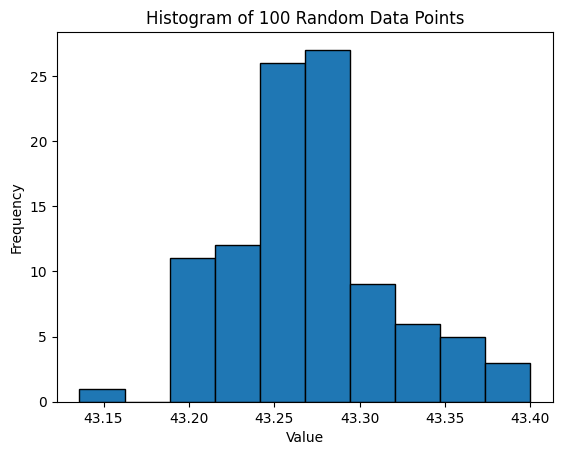

In [28]:
plt.hist(predicted_images.squeeze()[0], bins=10, edgecolor='black')
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 100 Random Data Points')

# Show the plot
plt.show()

## Inspect model on test data

In [29]:
model.eval()

MLP_diffusion_mixednormal(
  (input_projection): Linear(in_features=1, out_features=128, bias=True)
  (time_projection): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (blocks): Sequential2Inputs(
    (0): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (4): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)


In [30]:
TEST_SAMPLE_IDX = 20

target, conditioning = test_dataset[TEST_SAMPLE_IDX]
target, conditioning = target.to(device), conditioning.to(device) 
pred = regressor(conditioning).detach()

In [31]:
# x = torch.randn((1,1,1)).to(device)
# print(f"x = {x}; pred = {pred}")
# x += pred

N_SAMPLES = 100
TIMESTEPS = 50

i = 49
t = torch.tensor([i]).long().to(device)

ddim_sigma = 0.0

In [32]:
x_repeated = torch.randn((N_SAMPLES,1,1)).to(device) # x.repeat_interleave(N_SAMPLES, dim=0)
t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)
cond_repeated = conditioning.unsqueeze(1).repeat_interleave(N_SAMPLES, dim=0)
pred_repeated = pred.unsqueeze(1).repeat_interleave(N_SAMPLES, dim=0)

x_repeated += pred_repeated

print(f"x[0]={round(x_repeated.squeeze()[0].item(), 3)}, pred={round(pred_repeated.squeeze()[0].item(), 3)}, target={round(target.item(), 3)}")
print(f"mean(x)={x_repeated.mean().item()}, std(x)={x_repeated.std().item()}")

x[0]=0.849, pred=-0.706, target=-0.693
mean(x)=-0.6332890391349792, std(x)=1.024904489517212


In [33]:
beta_start = 1e-4
beta_end = 0.02
BETA = torch.linspace(beta_start, beta_end, TIMESTEPS).to(device)

ALPHA = 1.0 - BETA
ALPHA_HAT = torch.cumprod(ALPHA, dim=0)        

### Closed-form mixednormal

In [34]:
def sample_x_t_closed_form(
    x, t, predicted_noise_distribution_params, pred, i, method, final_timestep_variance_scaling=1.0,
):
    if method == "closed_form_normal":
        predicted_noise_mu = predicted_noise_distribution_params[..., 0]
        predicted_noise_sigma = predicted_noise_distribution_params[..., 1]
    elif method == "closed_form_mixednormal":
        mu = predicted_noise_distribution_params[..., 0]
        sigma = predicted_noise_distribution_params[..., 1]
        weights = predicted_noise_distribution_params[..., 2]
        sampled_weights = torch.distributions.Categorical(weights).sample()
        predicted_noise_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1)).squeeze(-1)
        predicted_noise_sigma = torch.gather(
            sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
        ).squeeze(-1)
    else:
        raise Exception(f"Invalid method {method}")
    
    alpha = ALPHA[t]
    alpha_hat = ALPHA_HAT[t]
    beta = BETA[t]
    # Reshape
    alpha = alpha.view(*alpha.shape, *(1,) * (x.ndim - alpha.ndim)).expand(x.shape)
    alpha_hat = alpha_hat.view(
        *alpha_hat.shape, *(1,) * (x.ndim - alpha_hat.ndim)
    ).expand(x.shape)
    beta = beta.view(*beta.shape, *(1,) * (x.ndim - beta.ndim)).expand(x.shape)
    if i > 1:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    variance_factor_default = beta**2 / (alpha * (1 - alpha_hat))

    y_hat_0 = (
        1
        / torch.sqrt(alpha_hat)
        * (
            x
            - (1 - torch.sqrt(alpha_hat)) * pred
            - torch.sqrt(1 - alpha_hat) * predicted_noise_mu
        )
    )
    if i > 1:
        alpha_hat_t_minus_1 = alpha_hat[t - 1]
        alpha_hat_t_minus_1 = alpha_hat_t_minus_1.view(
            *alpha_hat_t_minus_1.shape,
            *(1,) * (x.ndim - alpha_hat_t_minus_1.ndim),
        ).expand(x.shape)

        gamma_0 = beta * torch.sqrt(alpha_hat_t_minus_1) / (1 - alpha_hat)
        gamma_1 = (
            (1 - alpha_hat_t_minus_1) * torch.sqrt(alpha) / (1 - alpha_hat)
        )
        gamma_2 = 1 + (torch.sqrt(alpha_hat) - 1) * (
            torch.sqrt(alpha) + torch.sqrt(alpha_hat_t_minus_1)
        ) / (1 - alpha_hat)

        beta_wiggle = (1 - alpha_hat_t_minus_1) / (1 - alpha_hat) * beta

        variance_factor_CARD = alpha_hat_t_minus_1 * variance_factor_default
        if i == 1:
            variance_factor_CARD *= final_timestep_variance_scaling

        x = (gamma_0 * y_hat_0 + gamma_1 * x + gamma_2 * pred) + ddim_sigma * torch.sqrt(
            variance_factor_CARD * (predicted_noise_sigma)**2 + beta_wiggle
        ) * noise
    else:
        x = y_hat_0
        
    return x

In [35]:
if not deterministic:
    with torch.no_grad():
        x_closedform = x_repeated.clone()

        distr_per_t_closed_form = [
            (x_closedform.mean().cpu(), x_closedform.std().cpu())
        ]
        x_trajectories_closedform = [
            x_closedform
        ]

        for i in reversed(range(1, TIMESTEPS)):
            if i == 1:
                print("HI")
            t = torch.tensor([i]).long().to(device)
            curr_t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)
            #curr_t_repeated = t_repeated
            
            predicted_noise_distribution_params = model(
                x_closedform, curr_t_repeated, cond_repeated, pred_repeated,
            )

            x_closedform = sample_x_t_closed_form(
                x_closedform,
                curr_t_repeated,
                predicted_noise_distribution_params,
                pred_repeated,
                i,
                "closed_form_mixednormal",
            )

            distr_per_t_closed_form.append(
                (x_closedform.mean(axis=0).cpu(), x_closedform.std(axis=0).cpu())
            )
            x_trajectories_closedform.append(
                x_closedform
            )

HI


### Sample mixednormal

In [36]:
def sample_noise(model, x, t, conditioning, pred):
    predicted_mixture = model(x, t, conditioning, pred)
    mu = predicted_mixture[..., 0]
    sigma = predicted_mixture[..., 1]
    weights = predicted_mixture[..., 2]
    sampled_weights = torch.distributions.Categorical(weights).sample()
    sampled_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1))
    sampled_sigma = torch.gather(
        sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
    )
    predicted_noise = sampled_mu + sampled_sigma * torch.randn_like(
        sampled_mu, device=device
    )
    predicted_noise = predicted_noise.squeeze(-1)

    #print(f"sampled_mu={sampled_mu.squeeze()}; sampled_sigma={sampled_sigma.squeeze()}")

    return predicted_noise

In [37]:
def sample_x_t_inference(x, t, predicted_noise, pred, i):
    alpha = ALPHA[t]
    alpha_hat = ALPHA_HAT[t]
    beta = BETA[t]
    # Reshape
    alpha = alpha.view(*alpha.shape, *(1,) * (x.ndim - alpha.ndim)).expand(x.shape)
    alpha_hat = alpha_hat.view(
        *alpha_hat.shape, *(1,) * (x.ndim - alpha_hat.ndim)
    ).expand(x.shape)
    beta = beta.view(*beta.shape, *(1,) * (x.ndim - beta.ndim)).expand(x.shape)
    if i > 1:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    y_hat_0 = (
        1
        / torch.sqrt(alpha_hat)
        * (
            x
            - (1 - torch.sqrt(alpha_hat)) * pred
            - torch.sqrt(1 - alpha_hat) * predicted_noise
        )
    )
    if i > 1:
        alpha_hat_t_minus_1 = alpha_hat[t - 1]
        alpha_hat_t_minus_1 = alpha_hat_t_minus_1.view(
            *alpha_hat_t_minus_1.shape,
            *(1,) * (x.ndim - alpha_hat_t_minus_1.ndim),
        ).expand(x.shape)

        gamma_0 = beta * torch.sqrt(alpha_hat_t_minus_1) / (1 - alpha_hat)
        gamma_1 = (
            (1 - alpha_hat_t_minus_1) * torch.sqrt(alpha) / (1 - alpha_hat)
        )
        gamma_2 = 1 + (torch.sqrt(alpha_hat) - 1) * (
            torch.sqrt(alpha) + torch.sqrt(alpha_hat_t_minus_1)
        ) / (1 - alpha_hat)

        beta_wiggle = (1 - alpha_hat_t_minus_1) / (1 - alpha_hat) * beta

        x = (
            gamma_0 * y_hat_0
            + gamma_1 * x
            + gamma_2 * pred
            + ddim_sigma * torch.sqrt(beta_wiggle) * noise
        )

    else:
        x = y_hat_0

    return x

In [38]:
if not deterministic:
    with torch.no_grad():
        x_sampledform = x_repeated.clone()

        distr_per_t_sampled_form = [
            (x_sampledform.mean().cpu(), x_sampledform.std().cpu())
        ]
        x_trajectories_sampledform = [
            x_sampledform
        ]

        for i in reversed(range(1, TIMESTEPS)):
            predicted_noise = sample_noise(model, x_sampledform, t_repeated, cond_repeated, pred_repeated)
            x_sampledform = sample_x_t_inference(x_sampledform, t_repeated, predicted_noise, pred_repeated, i)

            distr_per_t_sampled_form.append(
                (x_sampledform.mean(axis=0).cpu(), x_sampledform.std(axis=0).cpu())
            )
            x_trajectories_sampledform.append(
                x_sampledform
            )


### Deterministic

In [39]:
if deterministic:
    with torch.no_grad():
        x_deterministic = x_repeated.clone()

        distr_per_t_deterministic = [
            (x_deterministic.mean().cpu(), x_deterministic.std().cpu())
        ]
        x_trajectories_deterministic = [
            x_deterministic
        ]

        for i in reversed(range(1, TIMESTEPS)):
            predicted_noise = model(x_deterministic, t_repeated, cond_repeated, pred_repeated)
            x_deterministic = sample_x_t_inference(x_deterministic, t_repeated, predicted_noise, pred_repeated, i)

            distr_per_t_deterministic.append(
                (x_deterministic.mean(axis=0).cpu(), x_deterministic.std(axis=0).cpu())
            )

            x_trajectories_deterministic.append(
                x_deterministic
            )

### Plots

#### Closed-form

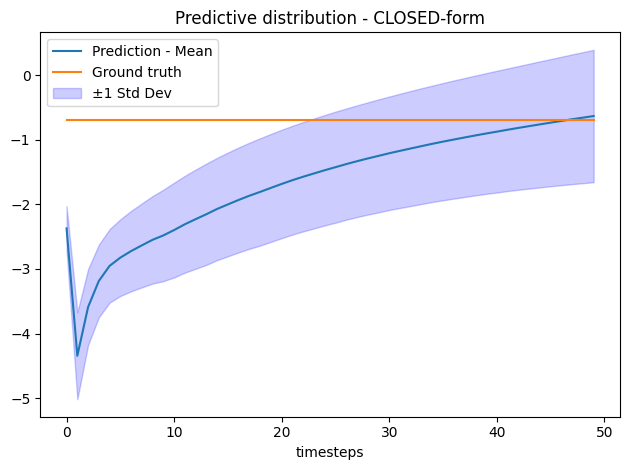

In [40]:
if not deterministic:
    means_over_time_closed_form = np.array([distr_per_t_closed_form[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_closed_form =  np.array([distr_per_t_closed_form[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_closed_form, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_closed_form - stds_over_time_closed_form, means_over_time_closed_form + stds_over_time_closed_form, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - CLOSED-form")
    plt.tight_layout()
    stds_over_time_closed_form

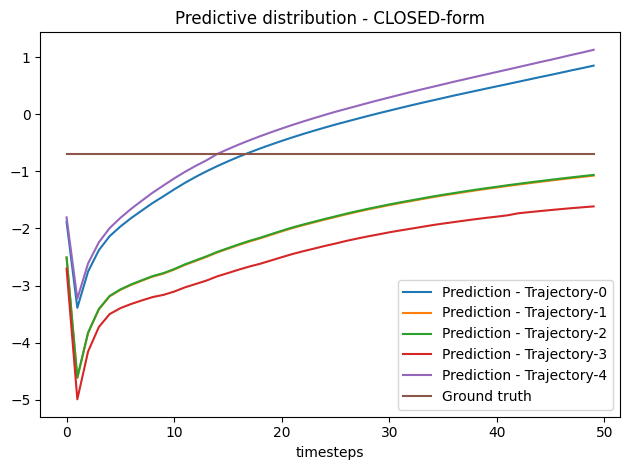

In [41]:
if not deterministic:
    x_trac_tensor = torch.concat(x_trajectories_closedform, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - CLOSED-form")
    plt.tight_layout()

#### Sampled-form

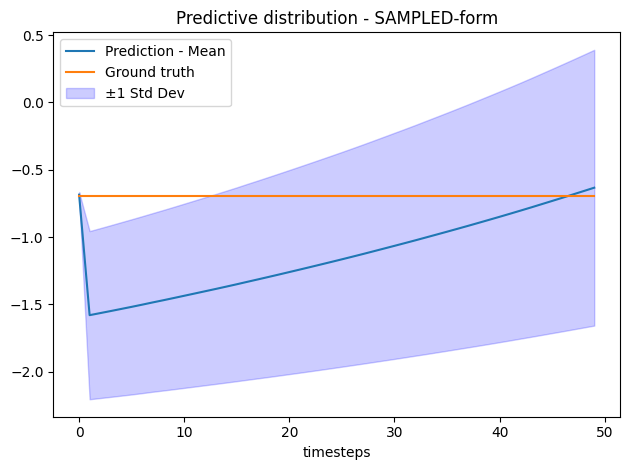

In [42]:
if not deterministic:
    means_over_time_sampled_form = np.array([distr_per_t_sampled_form[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_sampled_form =  np.array([distr_per_t_sampled_form[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_sampled_form, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_sampled_form - stds_over_time_sampled_form, means_over_time_sampled_form + stds_over_time_sampled_form, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - SAMPLED-form")
    plt.tight_layout()
    stds_over_time_sampled_form

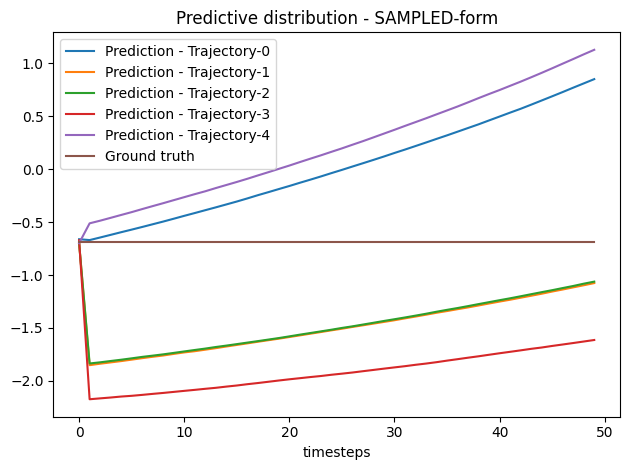

In [43]:
if not deterministic:
    x_trac_tensor = torch.concat(x_trajectories_sampledform, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - SAMPLED-form")
    plt.tight_layout()

#### Deterministic

In [44]:
if deterministic:
    means_over_time_deterministic = np.array([distr_per_t_deterministic[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_deterministic =  np.array([distr_per_t_deterministic[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_deterministic, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_deterministic - stds_over_time_deterministic, means_over_time_deterministic + stds_over_time_deterministic, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - DETERMINISTIC")
    plt.tight_layout()

In [45]:
if deterministic:

    x_trac_tensor = torch.concat(x_trajectories_deterministic, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - DETERMINISTIC")
    plt.tight_layout()

### Why?

In [46]:
def sample_x_t_training(x, eps, t, pred=None):
    alpha = ALPHA[t]
    alpha_hat = ALPHA_HAT[t]
    beta = BETA[t]

    sqrt_alpha_hat = torch.sqrt(alpha_hat)
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)
    # Reshape
    sqrt_alpha_hat = sqrt_alpha_hat.view(
        *sqrt_alpha_hat.shape, *(1,) * (x.ndim - sqrt_alpha_hat.ndim)
    ).expand(x.shape)
    sqrt_one_minus_alpha_hat = sqrt_one_minus_alpha_hat.view(
        *sqrt_one_minus_alpha_hat.shape,
        *(1,) * (x.ndim - sqrt_one_minus_alpha_hat.ndim),
    ).expand(x.shape)

    target_training = (
        sqrt_alpha_hat * x
        + sqrt_one_minus_alpha_hat * eps
        + (1 - sqrt_alpha_hat) * pred
    )
    return target_training

def noise_low_dimensional(x, t, pred=None):

    eps = x = torch.randn(x.shape).to(device)
    x_t = sample_x_t_training(x, eps, t, pred)
    return x_t, eps

In [47]:
curr_t = torch.tensor([49]).long().to(device)
x_t, noise = noise_low_dimensional(target, curr_t, pred=pred)

predicted_noise = model(x_t, curr_t, conditioning, pred)

In [48]:
noise

tensor([[1.7145]], device='cuda:0')

In [49]:
x_t

tensor([[2.2538]], device='cuda:0')

In [50]:
predicted_noise

tensor([[[[[6.0003e+00, 5.4433e-02, 2.1316e-04],
           [4.8776e+00, 4.2500e-02, 9.9979e-01]]]]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)